In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard

from wordcloud import WordCloud
%matplotlib inline


### READING ANIMELIST.CSV

In [6]:
import os

In [7]:
INPUT_DIR = os.path.join("..", "artifacts","raw")

In [8]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=['user_id','anime_id','rating'])

In [9]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [10]:
len(rating_df)

5000000

### DATA PROCESSING

In [11]:
## Select the user depending on the number of ratings
n_rating  = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_rating[n_rating > 400].index)].copy()

In [12]:
len(rating_df)

3242641

In [13]:
min_rating = min(rating_df["rating"])

In [ ]:
max_rating = max(rating_df["rating"])

In [15]:
avg_rating = np.mean(rating_df["rating"])

In [16]:
max_rating, min_rating, avg_rating

(10, 0, np.float64(4.122023992171813))

In [17]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

In [18]:
avg_rating = np.mean(rating_df["rating"])
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating, min_rating, max_rating

(np.float64(0.41220239921718105), 0.0, 1.0)

In [19]:
rating_df.duplicated().sum()

np.int64(0)

In [20]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [21]:
## Create new id for user after delete some of them
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i, x in enumerate(user_ids)}
user2user_decoded = {i : x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [22]:
n_users = len(user2user_encoded)
n_users

4193

In [85]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [86]:
n_animes = len(anime2anime_encoded)
n_animes

17149

In [87]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [88]:
rating_df

,user_id,anime_id,rating,user,anime
0,7809,2772,0.0,1968,1618
1,12267,37491,0.0,3097,2699
2,13206,33255,0.9,3347,1148
3,3120,10719,0.7,766,721
4,2310,9289,0.0,577,1807
...,...,...,...,...,...
3242636,9547,17247,0.9,2381,2208
3242637,14255,1015,0.7,3635,248
3242638,1752,777,0.9,452,2233
3242639,14926,22265,0.7,3795,452


In [89]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values

In [90]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

X_train, X_test, y_train, y_test = (
    X[:train_indices], X[train_indices:],
    y[:train_indices], y[train_indices:]
)

In [91]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3241641, 1000, 3241641, 1000)

In [92]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [93]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [94]:
type(X_train_array), type(X_train_array[0])

(list, numpy.ndarray)

#### MODEL ARCHITECTURE

In [95]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])

    user_embedding = Embedding(name="User_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])

    anime_embedding = Embedding(name="anime_embedding", input_dim=n_animes, output_dim=embedding_size)(anime)

    x = Dot(name="Dot_product", normalize=True, axes=2)([user_embedding, anime_embedding]) #Similarity between user and anime

    x = Flatten()(x)

    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer='Adam')

    return model



In [96]:
model = RecommenderNet()

In [97]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User_embedding      │ (None, 1, 128)    │    536,704 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_product (Dot)   │ (None, 1, 1)      │          0 │ User_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ Dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,731,782 (10.42 MB)

 Trainable params: 2,731,780 (10.42 MB)

 Non-trainable params: 2 (8.00 B)

In [98]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch - ramup_epochs-sustain_epochs)+min_lr

In [99]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [100]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [101]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size= batch_size,
    epochs=50,
    verbose=1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.8034 - mae: 0.3827 - mse: 0.1982 - val_loss: 0.7404 - val_mae: 0.3658 - val_mse: 0.1740 - learning_rate: 1.0000e-05
Epoch 2/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.7999 - mae: 0.3815 - mse: 0.1969 - val_loss: 0.7865 - val_mae: 0.3723 - val_mse: 0.1889 - learning_rate: 1.8000e-05
Epoch 3/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.7943 - mae: 0.3791 - mse: 0.1946 - val_loss: 0.7884 - val_mae: 0.3727 - val_mse: 0.1895 - learning_rate: 2.6000e-05
Epoch 4/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.7859 - mae: 0.3760 - mse: 0.1913 - val_loss: 0.7860 - val_mae: 0.3725 - val_mse: 0.1887 - learning_rate: 3.4000e-05


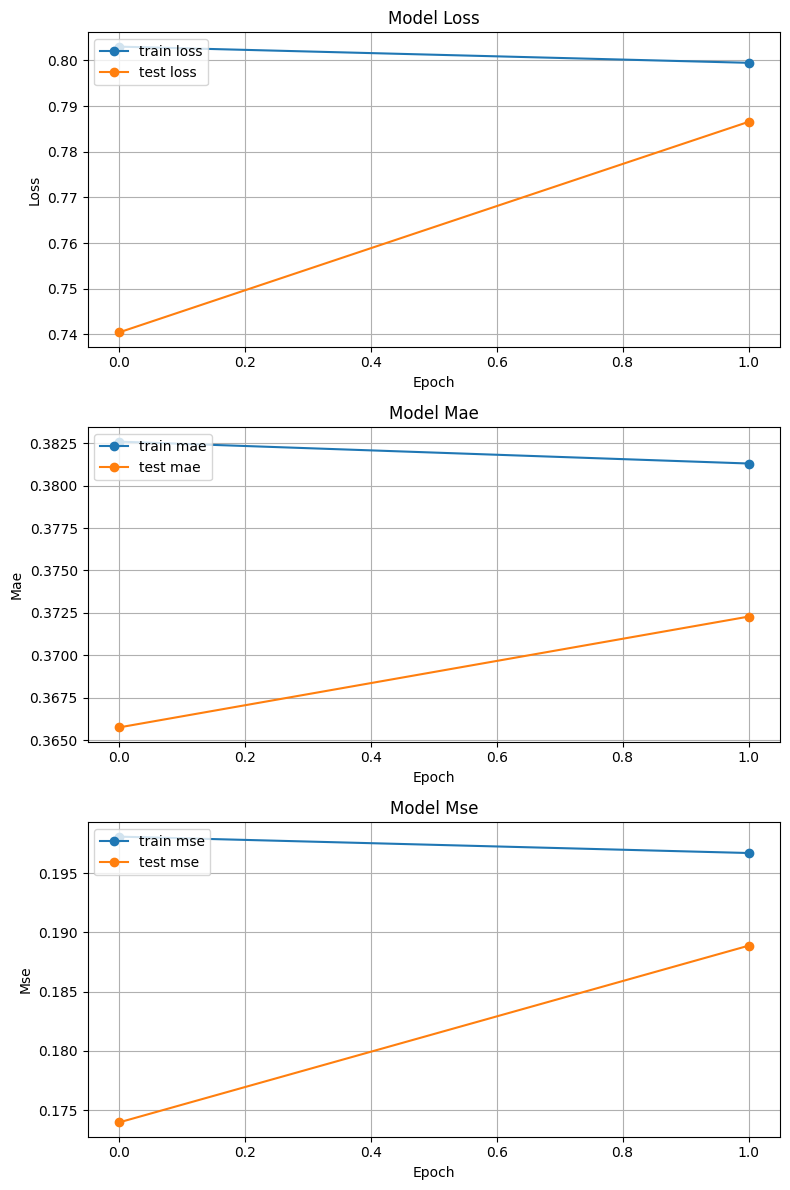

In [102]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [103]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape(-1, 1)
    return weights

In [104]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("User_embedding", model)

#### READING ANIME.CSV

In [105]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [106]:
df.shape

(17562, 35)

In [107]:
df = df.replace("Unknown", np.nan)

In [108]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]

    except:
        print("Erreur")
    return name

In [109]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [110]:
getAnimeName(6702)

'Fairy Tail'

In [111]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [112]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [113]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [114]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [115]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    elif isinstance(anime, str):
        return df[df.eng_version == anime]

In [116]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [117]:
getAnimeFrame("Attack on Titan Final Season", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


#### ANIME_WITH_SYNOPSIS.CSV

In [118]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [119]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols = cols)

In [120]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [121]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    elif isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [122]:
getSynopsis(40028, df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [123]:
getSynopsis("Steins;Gate", df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### COMTENT/ITEM BASED RECOMMANDATION

In [124]:
# Permet de voir toute les infos des colonnes
pd.set_option("max_colwidth", None)

In [125]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

In [126]:
find_similar_animes(
    "Cowboy Bebop",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=5
)

,name,similarity,genre
4,Haruniwa Ie no 3 Nin-me,0.304663,"Slice of Life, Comedy, Supernatural"
3,Star Driver the Movie,0.294459,"Action, Mecha, Romance, Shounen"
2,Kizuna (ONA),0.291200,Drama
1,Koeda-chan CMs,0.289770,Kids
0,Grimm's Fairy Tale Classics,0.289358,"Adventure, Comedy, Fantasy, Kids, Magic"


### USER BASED RECOMMENDATION

In [127]:
def find_similar_user(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decode_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similiar_users" : decode_id,
                    "similarity" : similarity
                })

        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similiar_users != item_input]

        return similar_users

    except Exception as e:
        print("Error occured !", e)

In [128]:
find_similar_user(int(7895), user_weights, user2user_encoded, user2user_decoded)

,similiar_users,similarity
9,6241,0.291300
8,2950,0.282142
7,9957,0.281460
6,14356,0.272467
5,11024,0.270497
4,11015,0.267864
3,6941,0.266906
2,2194,0.266845
1,5899,0.263711
0,4761,0.261649


In [129]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [130]:
from collections import defaultdict

In [131]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)

    return genres_list

In [132]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,7809,2772,0.0,1968,1618
1,12267,37491,0.0,3097,2699


In [133]:
def get_user_preferences(user_id, rating_df, df, plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows



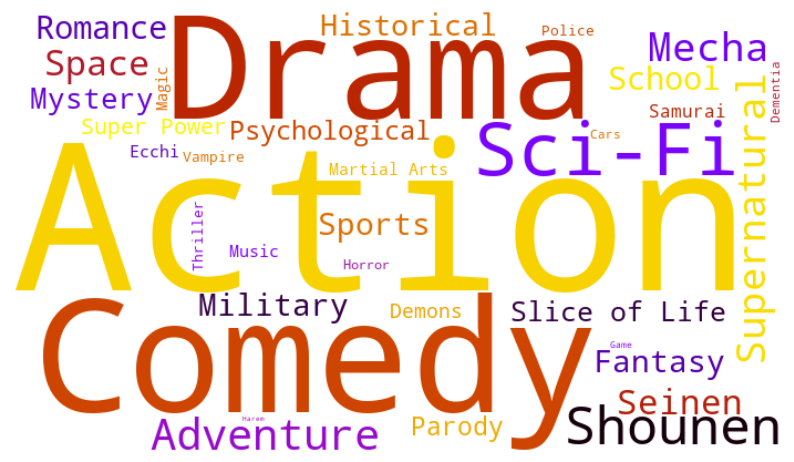

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [134]:
get_user_preferences(11880, rating_df, df, plot=True)

In [135]:
def get_user_recommendation(simmilar_users, user_pref, df, synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in simmilar_users.similiar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)

                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)

                recommended_animes.append({
                    "n" : n_user_pref,
                    "anime_name" : anime_name,
                    "Genres" : genre,
                    "Synopsis": synopsis
                })

    return pd.DataFrame(recommended_animes).head(n)    


In [136]:
similar_users = find_similar_user(int(11880), user_weights, user2user_encoded, user2user_decoded)

In [137]:
user_pref = get_user_preferences(int(11880),rating_df, df)

In [138]:
get_user_recommendation(similar_users, user_pref, df, synopsis_df, rating_df)

,n,anime_name,Genres,Synopsis
0,9,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","aku Ichijou, a first-year student at Bonyari High School, is the sole heir to an intimidating yakuza family. Ten years ago, Raku made a promise to his childhood friend. Now, all he has to go on is a pendant with a lock, which can only be unlocked with the key which the girl took with her when they parted. Now, years later, Raku has grown into a typical teenager, and all he wants is to remain as uninvolved in his yakuza background as possible while spending his school days alongside his middle school crush Kosaki Onodera. However, when the American Bee Hive Gang invades his family's turf, Raku's idyllic romantic dreams are sent for a toss as he is dragged into a frustrating conflict: Raku is to pretend that he is in a romantic relationship with Chitoge Kirisaki, the beautiful daughter of the Bee Hive's chief, so as to reduce the friction between the two groups. Unfortunately, reality could not be farther from this whopping lie—Raku and Chitoge fall in hate at first sight, as the girl is convinced he is a pathetic pushover, and in Raku's eyes, Chitoge is about as attractive as a savage gorilla. Nisekoi follows the daily antics of this mismatched couple who have been forced to get along for the sake of maintaining the city's peace. With many more girls popping up his life, all involved with Raku's past somehow, his search for the girl who holds his heart and his promise leads him in more unexpected directions than he expects."
1,8,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
2,8,Your Name.,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,8,Your Lie in April,"Drama, Music, Romance, School, Shounen","usic accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the

### Hybrid Recommender System

In [149]:
def hybrid_recommendation(user_id, user_weight=0.4, content_weight = 0.6):

    #### User recommendation 

    similar_users = find_similar_user(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendation(similar_users, user_pref, df, synopsis_df, rating_df)

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()

    print(user_recommended_anime_list)

    #### Content recommendation 
    content_recommended_animes = []
    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights,anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")

    combined_score = {}

    for anime in user_recommended_anime_list:
        combined_score[anime] = combined_score.get(anime, 0) + user_weight
    for anime in content_recommended_animes:
        combined_score[anime] = combined_score.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_score.items(), key=lambda x: x[1], reverse=True)
          
    return [anime for anime, score in sorted_animes[:10]]

In [148]:
hybrid_recommendation(15597)

['Bakuman.', 'Fate/Zero', 'Fate/Zero Season 2', 'Daily Lives of High School Boys', 'Fate/stay night [Unlimited Blade Works] Season 2', "Kuroko's Basketball", 'Fate/stay night:Unlimited Blade Works - Prologue', 'Mushi-Shi', 'Darker than Black', 'Maid Sama!']


["Muhyo & Roji's Bureau of Supernatural Investigation 2nd Season",
 'Blood:The Last Vampire',
 'Tobe! Pegasus Kokoro no Goal ni Shoot',
 'Spring has come!',
 'Kumo no Mori no Marcus',
 'Saki',
 'Business Fish',
 'Inu X Boku Secret Service Special',
 'Hamster Club',
 'One Piece:Chopper Kingdom of Strange Animal Island']